# Datamining 7331 Lab 2: Analysis of Airbnb data using Classification and Regression

By: William Arnost, Stephen Johnson, Sean Kennedy, Tazeb Abera

## Introduction

In this notebook we will be predicting the room type and price features from the Airbnb data set using different algorithms. 

Room type can take 3 values: 'Private room', 'Entire home/apt', and 'Shared room'. We will drop shared room and focus on the other two classes. Room type by itself might not be a useful thing to predict, but we are hoping this can teach us something about our data for a future price prediction exercise. 

[Describe Price]

[Describe other main topics]

## Contents
<link1>
<link2>
<...>

## Data Preparation Part 1

### Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

### Package Loading

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

#sns.set(style="ticks", color_codes=True)
# sklearn stuff
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit



#yellobrick stuff
from yellowbrick.classifier import ConfusionMatrix, DiscriminationThreshold, PrecisionRecallCurve, ClassificationReport, ClassPredictionError, ROCAUC
from yellowbrick.target import ClassBalance
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Define Functions for model analysis

In [86]:
def analyze_classifier(model,
                       X_train,
                       X_test,
                       y_train,
                       y_test,
                       response='Response',
                       classes=[0, 1]):
    matrix = ConfusionMatrix(model, classes=classes)
    matrix.fit(X_train, y_train[response])
    matrix.score(X_test, y_test[response])
    matrix.show()
    class_report = ClassificationReport(model, classes=classes, support=True)
    class_report.fit(X_train, y_train[response])
    class_report.score(X_test, y_test[response])
    class_report.show()
    roc_auc = ROCAUC(model, classes=classes)
    roc_auc.fit(X_train, y_train[response])
    roc_auc.score(X_test, y_test[response])
    roc_auc.show()
    recall = PrecisionRecallCurve(model)
    recall.fit(X_train, y_train)
    recall.score(X_test, y_test)
    recall.show()
    if len(classes) == 2:
        disc_thresh = DiscriminationThreshold(model)
        disc_thresh.fit(X_train, y_train.values.ravel())
        disc_thresh.show()
        return disc_thresh.thresholds_, disc_thresh.cv_scores_
    else:
        return None, None


def sklearn_vif(exogs, data):

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # form input data for each exogenous variable
    for exog in exogs:
        #print(exog)
        not_exog = [i for i in exogs if i != exog]
        #print(not_exog)
        X, y = data[not_exog], data[exog]

        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        vif = 1 / (1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif


def compute_new_conf_matrix(predictions, probabilities, cutoff, y_test):
    #create a df of predictions and probabilities
    predictions = pd.DataFrame(list(predictions), columns=['Predict'])
    predicted_probs = pd.concat([
        pd.DataFrame(list(probabilities), columns=['ProbFalse', 'ProbTrue']),
        predictions
    ],
                                axis=1)
    #make array of values where val > cutoff
    predicted_probs['NewPredict'] = predicted_probs['ProbTrue'].apply(
        lambda x: 1 if x >= cutoff else 0)
    matrix = pd.DataFrame(confusion_matrix(y_test, predicted_probs.NewPredict))
    matrix.rename(columns={
        0: 'No_Predicted',
        1: 'Yes_Predicted'
    },
                  index={
                      0: 'No_True',
                      1: 'Yes_True'
                  },
                  inplace=True)
    return round(accuracy_score(y_test, predicted_probs.NewPredict),
                 5), matrix, predicted_probs


def transform_data(X_train, X_test, y_train, y_test):
    #OH encode
    label_encode = [
        x for x, y in dict(X_train.dtypes).items()
        if type(y) == pd.CategoricalDtype
    ]
    for var in label_encode:
        #impute to Mode
        print(f"{var} was OHE'd")
        X_train[var].fillna(X_train[var].mode()[0], inplace=True)
        X_test[var].fillna(X_train[var].mode()[0], inplace=True)
        cat_list_train = pd.get_dummies(X_train[var], prefix=var)
        cat_list_test = pd.get_dummies(X_test[var], prefix=var)
        X_train_new = X_train.join(cat_list_train)
        X_train = X_train_new
        X_test_new = X_test.join(cat_list_test)
        X_test = X_test_new

    normalize = [x for x, y in dict(X_train.dtypes).items() if y == np.float64]
    for col in normalize:
        #change impution scheme?
        print(f"{col} was Standard Scaled")
        X_train[col].fillna(X_train[col].median(), inplace=True)
        X_test[col].fillna(X_train[col].median(), inplace=True)
        normalizer = StandardScaler()
        ar_train = X_train[col].to_numpy().reshape(-1, 1)
        normalizer.fit(ar_train)
        X_train.loc[:, col] = normalizer.transform(ar_train)
        ar_test = X_test[col].to_numpy().reshape(-1, 1).copy()
        X_test.loc[:, col] = normalizer.transform(ar_test)

    X_train.drop(columns=label_encode, inplace=True)
    X_test.drop(columns=label_encode, inplace=True)
    X_train.drop(columns=target_col, inplace=True)
    X_test.drop(columns=target_col, inplace=True)
    
    return X_train, X_test, y_train, y_test

### Read in the data

In [77]:
data = pd.read_csv('ABNB_NY_V2.csv')
summary = data.describe()
print({x: len(data[x].unique()) for x in data.columns})
summary

{'id': 48895, 'name': 47897, 'host_id': 37457, 'host_name': 11453, 'neighbourhood_group': 5, 'neighbourhood': 221, 'latitude': 19048, 'longitude': 14718, 'room_type': 3, 'price': 674, 'minimum_nights': 109, 'number_of_reviews': 394, 'last_review': 1765, 'reviews_per_month': 938, 'calculated_host_listings_count': 47, 'availability_365': 366, 'ZIP': 199, 'dist_subway': 46157, 'cnt_all': 133, 'cnt_entire_home': 95, 'cnt_private_room': 74, 'cnt_shared_room': 14, 'avgprice_all': 1912, 'avgprice_entire_home': 1409, 'avgprice_private_room': 1309, 'avgprice_shared_room': 219}


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,ZIP,dist_subway,cnt_all,cnt_entire_home,cnt_private_room,cnt_shared_room,avgprice_all,avgprice_entire_home,avgprice_private_room,avgprice_shared_room
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000,48871.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327,10675.111211,0.245997,52.815768,29.719726,22.013396,1.082646,152.703409,191.493067,98.024409,40.581520
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289,599.591915,0.346640,43.303548,29.254144,18.668278,2.615105,90.678742,114.468382,73.981026,93.479089
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,10001.000000,0.000553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000,10024.000000,0.103457,20.000000,8.000000,7.000000,0.000000,94.812500,137.250000,64.500000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000,11104.000000,0.173022,43.000000,20.000000,17.000000,0.000000,135.208333,180.850000,83.666667,0.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000,11221.000000,0.269066,73.000000,42.000000,33.000000,1.000000,189.000000,231.264463,111.500000,60.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,11697.000000,4.931115,230.000000,142.000000,91.000000,26.000000,5000.000000,5000.000000,3000.000000,1800.000000


### Type Conversion

In [78]:
data['price'] = data['price'].astype('float')
data['minimum_nights'] = data['minimum_nights'].astype('float')
data['number_of_reviews'] = data['number_of_reviews'].astype('float')
data['calculated_host_listings_count'] = data[
    'calculated_host_listings_count'].astype('float')
data['availability_365'] = data['availability_365'].astype('float')
data['dist_subway'] = data['dist_subway'].astype('float')
data['cnt_all'] = data['cnt_all'].astype('float')
data['cnt_all'] = data['cnt_all'].astype('float')
data['cnt_entire_home'] = data['cnt_entire_home'].astype('float')
data['cnt_private_room'] = data['cnt_private_room'].astype('float')
data['cnt_shared_room'] = data['cnt_shared_room'].astype('float')
data['avgprice_all'] = data['avgprice_all'].astype('float')
data['avgprice_entire_home'] = data['avgprice_entire_home'].astype('float')
data['avgprice_private_room'] = data['avgprice_private_room'].astype('float')
data['avgprice_shared_room'] = data['avgprice_shared_room'].astype('float')
data['neighbourhood_group'] = data['neighbourhood_group'].astype('category')
data['neighbourhood'] = data['neighbourhood'].astype('category')
data['ZIP'] = data['ZIP'].astype('category')
data['last_review'] = pd.to_datetime(data['last_review'])

data['days_since_last_review'] = (
    dt.datetime.strptime('2020-01-01', '%Y-%m-%d') -
    data['last_review']).dt.days
data.days_since_last_review.fillna(data.days_since_last_review.max(),
                                   inplace=True)
data.drop(columns=['last_review'], inplace=True)

### Remove Outliers

In [79]:
data = data[data.price != 0].copy()
data = data[data.price < 300].copy()
data = data[data.minimum_nights <= 20].copy()

In [80]:
idx = data[data['room_type'] == 'Shared room'].index
data.drop(idx , inplace=True)

### Encode Target Variable

In [81]:
target_col = 'room_type'
room_types = {'Entire home/apt': 0, 'Private room': 1}
data['Response'] = data.apply(lambda x: room_types[x.room_type], axis=1)

### Drop Columns that won't be used in modeling

In [82]:
data.drop(
    columns=['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'ZIP'],
    inplace=True)

### Feature / Target Split

In [83]:
data_final = data
features, target = data_final.drop(
    columns=['Response']), data_final.loc[:, ['Response']]
features.shape, target.shape

((39156, 20), (39156, 1))

## Modeling and Evaluation 1

- Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.


## Modeling and Evaluation 2

- Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.


### Train Test Split

- For classification, we will start with a simple **5-fold StratifiedShuffleSplit 80/20** train/test split of our data. In this case we are looking to ensure that our classes are balanced (i.e have the same probability of being observed as they do in the dataset as a whole). The StratifiedKFold object in sklearn is designed to maintain class balance across all folds. From the **Yellowbrick ClassBalance** bar charts below, we can see that our classes are nearly perfectly balanced in our training and testing sets across all folds.


- After each train/test split is created, we will transform the data (OHE and normalization/impution) before passing the train/test sets to the classifier.

31324, 31324
7832, 7832
31324, 31324
7832, 7832
31324, 31324
7832, 7832
31324, 31324
7832, 7832
31324, 31324
7832, 7832


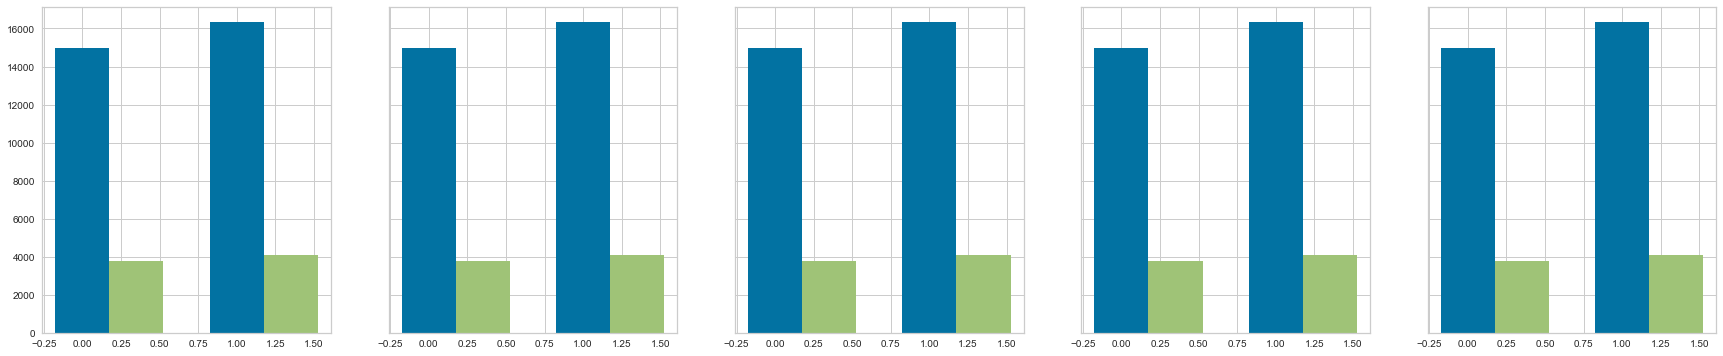

In [74]:
n_splits = 5
cv = StratifiedShuffleSplit(n_splits,test_size=.2, train_size=.8, random_state=5)
support = []
fold = 0
fig, ax = plt.subplots(1, 5, sharey=True, figsize=(30, 6))

for trainidx, testidx in cv.split(features, target):
    X_train = features.iloc[trainidx] 
    X_test = features.iloc[testidx] 
    y_train = target.iloc[trainidx]
    y_test = target.iloc[testidx]
    classes_test = ClassBalance(labels=['Entire home/apt', 'Private room'], ax=ax[fold])
    classes_test.fit(y_train['Response'], y_test['Response'])
    support.append(classes_test.support_)
    fold = fold + 1
    #print(f'{len(X_train)}, {len(y_train)}')
    #print(f'{len(X_test)}, {len(y_test)}')

## Modeling and Evaluation 3

- Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!

## Modeling and Evaluation 4

- Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

## Modeling and Evaluation 5

- Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.

## Modeling and Evaluation 6

- Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.